In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from NYC_GetCleaned_HistoricData import getCleanedDataFrame

from IPython.display import Image 
import io
from io import StringIO
import pydotplus
import graphviz
from sklearn import tree

In [14]:
import sys
!{sys.executable} -m pip install graphviz

  Using cached https://files.pythonhosted.org/packages/1f/e2/ef2581b5b86625657afd32030f90cf2717456c1d2b711ba074bf007c0f1a/graphviz-0.10.1-py2.py3-none-any.whl


In [15]:
import sys
!{sys.executable} -m pip install pydotplus

In [2]:
#Get cleaned historic dataframe
crimes_historic = getCleanedDataFrame()
crimes_historic.head()

,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,OFNS_DESC,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,ADDR_PCT_CD,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,Latitude,Longitude,Lat_Lon
1,3/30/2014,20:40:00,3/30/2014,20:50:00,3/30/2014,DANGEROUS DRUGS,"CONTROLLED SUBSTANCE,INTENT TO",ATTEMPTED,FELONY,BRONX,44.0,INSIDE,RESIDENCE - APT. HOUSE,40.836162,-73.915250,"(40.836161968, -73.915249813)"
2,4/16/2014,22:10:00,4/16/2014,22:12:00,4/17/2014,DANGEROUS DRUGS,"CONTROLLED SUBSTANCE,POSSESS.",ATTEMPTED,FELONY,BRONX,47.0,INSIDE,STREET,40.894671,-73.861361,"(40.894670712, -73.86136123)"
3,4/8/2014,13:45:00,4/8/2014,13:50:00,4/8/2014,DANGEROUS DRUGS,"CONTROLLED SUBSTANCE, SALE 5",ATTEMPTED,FELONY,BRONX,52.0,INSIDE,STREET,40.864191,-73.901183,"(40.864190693, -73.901182887)"
4,5/17/2014,21:17:00,5/17/2014,21:24:00,5/17/2014,FELONY ASSAULT,"ASSAULT 2,1,PEACE OFFICER",ATTEMPTED,FELONY,BRONX,40.0,INSIDE,STREET,40.813052,-73.908159,"(40.813051503, -73.908158845)"
5,4/26/2014,00:00:00,4/26/2014,00:01:00,4/26/2014,FELONY ASSAULT,"ASSAULT 2,1,UNCLASSIFIED",ATTEMPTED,FELONY,BRONX,41.0,INSIDE,STREET,40.814602,-73.885895,"(40.814601602, -73.885895461)"


In [4]:
# time boundaries
five_am = pd.Timestamp('5:00').time()
one_pm = pd.Timestamp('13:00').time()
nine_pm = pd.Timestamp('21:00').time()
midnight = pd.Timestamp('00:00').time()

#Calculating x_data
sum_5_13 = crimes_historic.BORO_NM[(crimes_historic.CMPLNT_FR_TM > five_am)
                                   & (crimes_historic.CMPLNT_FR_TM <= one_pm)].value_counts()
sum_13_21 = crimes_historic.BORO_NM[(crimes_historic.CMPLNT_FR_TM > one_pm)
                                   & (crimes_historic.CMPLNT_FR_TM <= nine_pm)].value_counts()
sum_21_5 = crimes_historic.BORO_NM[((crimes_historic.CMPLNT_FR_TM > nine_pm)
                                   & (crimes_historic.CMPLNT_FR_TM <= midnight))
                                   | ((crimes_historic.CMPLNT_FR_TM > midnight) 
                                   & (crimes_historic.CMPLNT_FR_TM <= five_am))].value_counts()

# x_data dataframe
x_df = pd.DataFrame({'sum_5_13': sum_5_13, 'sum_13_21': sum_13_21, 'sum_21_5': sum_21_5})


TypeError: '>' not supported between instances of 'str' and 'datetime.time'

In [3]:
crime_remCol = crimes_historic.drop(['CMPLNT_FR_DT','CMPLNT_FR_TM','CMPLNT_TO_DT','CMPLNT_TO_TM','RPT_DT','OFNS_DESC','PD_DESC','ADDR_PCT_CD', 'LOC_OF_OCCUR_DESC','PREM_TYP_DESC', 'Latitude', 'Longitude','Lat_Lon'], axis=1)
crime_remCol.shape

(5835784, 3)

In [4]:
X = crime_remCol.iloc[:, [1,2]].values
Y = crime_remCol.iloc[:, 0].values

In [5]:
Y

array(['ATTEMPTED', 'ATTEMPTED', 'ATTEMPTED', ..., 'COMPLETED',
       'COMPLETED', 'COMPLETED'], dtype=object)

In [6]:
# Encoding categorical data
# Encoding the Independent Variable
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_X = LabelEncoder()
X[:,0] = labelencoder_X.fit_transform(X[:,0])
X[:,1] = labelencoder_X.fit_transform(X[:,1])
onehotencoder = OneHotEncoder(categorical_features = [0])
X = onehotencoder.fit_transform(X).toarray() 


In [7]:
X.shape

(5835784, 4)

In [8]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

In [9]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [10]:
# Fitting Decision Tree Classification to the Training set
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [17]:
def plot_decision_tree(clf,feature_name,target_name):
    dot_data = StringIO()  
    tree.export_graphviz(clf, out_file=dot_data,  
                         feature_names=feature_name,  
                         class_names=target_name,  
                         filled=True, rounded=True,  
                         special_characters=True)  
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    return Image(graph.create_png())

In [18]:
plot_decision_tree(classifier,X_train[0:4], Y_train[0])

InvocationException: GraphViz's executables not found

In [21]:
# Predicting the Test set results
Y_pred = classifier.predict(X_test)

In [22]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, Y_pred)

In [23]:
cm

array([[      0,   19628],
       [      0, 1147529]], dtype=int64)

TypeError: Input z must be a 2D array.

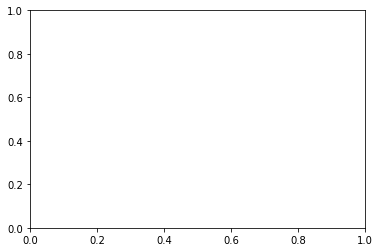

In [25]:
# Visualising the Training set results
from matplotlib.colors import ListedColormap
X_set, Y_set = X_train, Y_train
X1, X2,X3 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 2].min() - 1, stop = X_set[:, 2].max() + 1, step = 0.01),
                    )
plt.contourf(X1, X2,X3, classifier.predict(np.array([X1.ravel(), X2.ravel(), X3.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(Y_set)):
    plt.scatter(X_set[Y_set == j, 0], X_set[Y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Decision Tree Classification (Training set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()